In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from matplotlib import cm
from torch.utils.data import DataLoader, Dataset


from counterfactuals.datasets import LawDataset, MoonsDataset
from counterfactuals.generative_models import MaskedAutoregressiveFlowDistance as MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import (
    LogisticRegression,
    MultilayerPerceptron,
)
from counterfactuals.metrics import CFMetrics

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [9]:
class PairDistanceDataset(Dataset):
    def __init__(self, class_zero, class_one, length=None):
        """
        Initialize with two arrays, one for each class.
        """
        self.length = length
        self.class_zero = torch.tensor(class_zero, dtype=torch.float32).to(device)  # ✅ Move to CUDA
        self.class_one = torch.tensor(class_one, dtype=torch.float32).to(device)  # ✅ Move to CUDA

        # Calculate pairwise distances between zero and one classes
        self.zero_one_distance = torch.cdist(self.class_zero, self.class_one) ** 4

        self.size_zero = class_zero.shape[0]
        self.size_one = class_one.shape[0]

    def __len__(self):
        # The total combinations are len(class_zero) * len(class_one)
        if self.length is not None:
            return self.length
        return self.size_zero * self.size_one

    def get_specific_item(self, idx):
        """
        Get the specific item based on the index.
        Sample the second point based on the distance weight from another class.
        """
        if idx < self.size_zero:
            i = idx
            x_orig = self.class_zero[i]

            # Calculate weights for sampling y
            zero_one_weight = 1 / self.zero_one_distance[i]
            zero_one_weight /= zero_one_weight.sum()

            j = torch.multinomial(zero_one_weight, num_samples=1).item()
            x_cf = self.class_one[j]
        else:
            i = idx + self.size_zero
            x_orig = self.class_one[i]

            # Calculate weights for sampling y
            zero_one_weight = 1 / self.zero_one_distance[:, i]
            zero_one_weight /= zero_one_weight.sum()

            j = torch.multinomial(zero_one_weight, num_samples=1).item()
            x_cf = self.class_zero[j]
        return torch.tensor(x_cf, dtype=torch.float32), torch.tensor(
            x_orig, dtype=torch.float32
        )

    def __getitem__(self, idx):
        """
        Randomly select a point from one class.
        Sample the second point based on the distance weight from another class.
        """
        if torch.rand(1) > 0.5:
            i = torch.randint(0, self.size_zero, (1,)).item()
            x_orig = self.class_zero[i]

            # Calculate weights for sampling y
            zero_one_weight = 1 / self.zero_one_distance[i]
            zero_one_weight /= zero_one_weight.sum()

            j = torch.multinomial(zero_one_weight, num_samples=1).item()
            x_cf = self.class_one[j]
        else:
            i = torch.randint(0, self.size_one, (1,)).item()
            x_orig = self.class_one[i]

            # Calculate weights for sampling y
            zero_one_weight = 1 / self.zero_one_distance[:, i]
            zero_one_weight /= zero_one_weight.sum()

            j = torch.multinomial(zero_one_weight, num_samples=1).item()
            x_cf = self.class_zero[j]
        return torch.tensor(x_cf, dtype=torch.float32), torch.tensor(
            x_orig, dtype=torch.float32
        )

In [10]:
from counterfactuals.datasets import GermanCreditDataset, AdultDataset

# dataset = MoonsDataset(file_path="../../data/moons.csv")
# dataset = LawDataset(file_path="../../data/law.csv")
# dataset = GermanCreditDataset(file_path="data/german_credit.csv")
dataset = AdultDataset(file_path="data/adult.csv")

In [11]:
import time
from counterfactuals.generative_models import MaskedAutoregressiveFlow as baseMAF
dataset.X_train = np.array(dataset.X_train, dtype=np.float32)
dataset.y_train = np.array(dataset.y_train, dtype=np.float32)
dataset.X_test = np.array(dataset.X_test, dtype=np.float32)
dataset.y_test = np.array(dataset.y_test, dtype=np.float32)



flow_train_dataloader = dataset.train_dataloader(
    batch_size=128, shuffle=True, noise_lvl=0.03
)
flow_test_dataloader = dataset.test_dataloader(batch_size=128, shuffle=False)
global_start_time = time.time()

flow = baseMAF(
    features=dataset.X_test.shape[1],
    hidden_features=16,
    num_blocks_per_layer=4,
    num_layers=8,
    context_features=1,
    device=device
).to(device)
flow.fit(flow_train_dataloader, flow_test_dataloader, num_epochs=100, patience=50)

Epoch 99, Train: -77.9320, test: -79.7460, patience: 0: 100%|██████████| 100/100 [04:31<00:00,  2.71s/it]


In [12]:
disc_model = MultilayerPerceptron(
    input_size=29,  # Adjust based on the actual feature size of your dataset
    hidden_layer_sizes=[256, 256],
    target_size=1,
    dropout=0.2,
    device=device
).to(device)

train_dataloader = dataset.train_dataloader(batch_size=64, shuffle=True, noise_lvl=0.0)
test_dataloader = dataset.test_dataloader(batch_size=64, shuffle=False)
disc_model.fit(train_dataloader, test_dataloader, epochs=100, patience=100, lr=1e-3)

# validate
y_pred = disc_model.predict(dataset.X_test).cpu().detach().numpy()  # ✅ Fix added

y_true = dataset.y_test
print(f"Accuracy: {np.mean(y_pred == y_true)}")
# disc_model.load("../models/MoonsDataset/disc_model_MultilayerPerceptron.pt")

disc_model.eval()
dataset.y_train = disc_model.predict(dataset.X_train).cpu().detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).cpu().detach().numpy()

Epoch 99, Train: 0.3623, test: 0.3814, patience: 93: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]

Accuracy: 0.8275


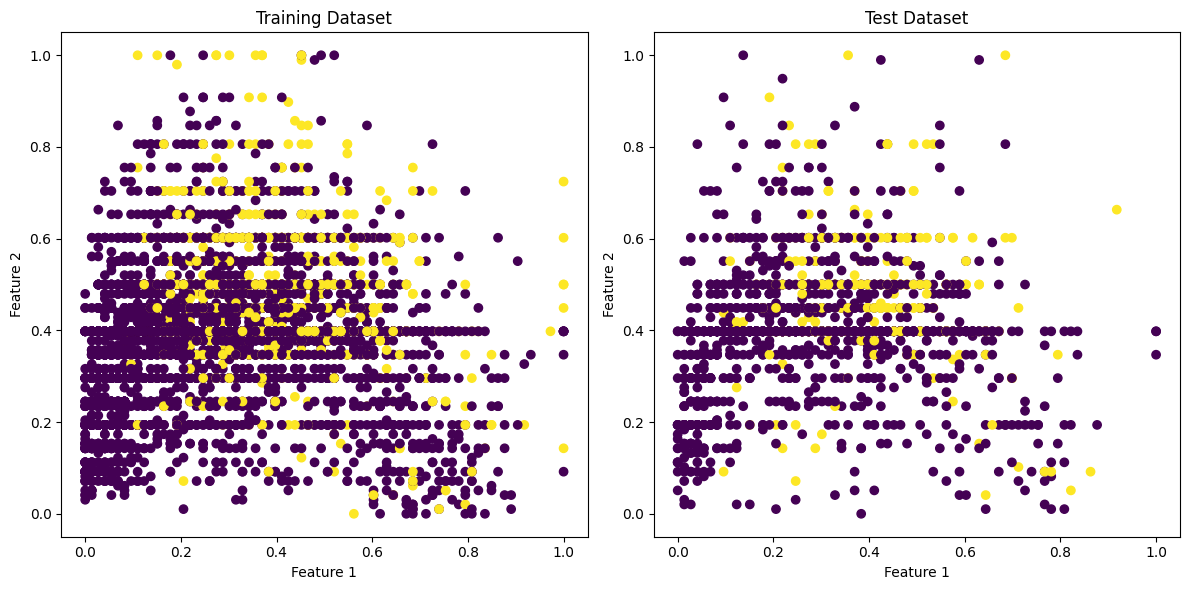

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot training dataset
axes[0].scatter(dataset.X_train[:, 0], dataset.X_train[:, 1], c=dataset.y_train, cmap='viridis', marker='o')
axes[0].set_title('Training Dataset')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# Plot test dataset
axes[1].scatter(dataset.X_test[:, 0], dataset.X_test[:, 1], c=dataset.y_test, cmap='viridis', marker='o')
axes[1].set_title('Test Dataset')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

In [14]:
class_zero = dataset.X_train[dataset.y_train == 0]
class_one = dataset.X_train[dataset.y_train == 1]

pair_dataset_train = PairDistanceDataset(class_zero, class_one, length=5000)


def collate_fn(batch):
    X, y = zip(*batch)
    X = torch.stack(X).to(device)
    y = torch.stack(y).to(device)
    noise = torch.randn_like(X) * 0.03
    noise = torch.randn_like(y) * 0.03
    X = X + noise
    y = y + noise
    return X, y


train_dataloader = DataLoader(
    pair_dataset_train, batch_size=256, shuffle=True, collate_fn=collate_fn
)
train_dataloader = DataLoader(pair_dataset_train, batch_size=128, shuffle=True)


In [15]:
class_zero = dataset.X_test[dataset.y_test == 0]
class_one = dataset.X_test[dataset.y_test == 1]

pair_dataset_test = PairDistanceDataset(class_zero, class_one)

test_dataloader = DataLoader(pair_dataset_test, batch_size=2048, shuffle=False)

In [16]:
cf = MaskedAutoregressiveFlow(
    features=dataset.X_test.shape[1],
    hidden_features=16,
    num_blocks_per_layer=2,
    num_layers=2,
    context_features=dataset.X_test.shape[1],
    device=device
).to(device)
cf.fit(
    train_dataloader, test_dataloader, num_epochs=1, learning_rate=1e-3, patience=100, lambda_dist=0.2, checkpoint_path="best_cf_model_dist_0.2_adult_cuda.pt"
)
cf.load("best_cf_model_dist_0.2_adult_cuda.pt")

  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/k_/2tytwy6d2ll1_kvk_k0j7vd00000gn/T/ipykernel_5316/2857889526.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_cf, dtype=torch.float32), torch.tensor(
Epoch 0, Train: 44.2412, Test: 31.7059, Patience: 0: 100%|██████████| 1/1 [02:10<00:00, 130.77s/it]


In [17]:
from tqdm import tqdm

cfs = []
with torch.no_grad():
    for x in dataset.X_test:
        points, log_prob = cf.sample_and_log_prob(
            100, context=torch.from_numpy(np.array([x]))
        )
        cfs.append(points)
cfs = torch.stack(cfs).squeeze().permute(1, 0, 2).cpu().numpy()
end_time = time.time() - global_start_time
print(f"Time to finish all: {end_time:.4f} seconds")
all_metrics = []
for i in tqdm(range(cfs.shape[0])):
    metrics = CFMetrics(
        X_cf=cfs[i],
        y_target=np.abs(dataset.y_test - 1),
        X_train=dataset.X_train,
        y_train=dataset.y_train,
        X_test=dataset.X_test,
        y_test=dataset.y_test,
        gen_model=flow, #cf, #flow
        disc_model=disc_model,
        continuous_features=dataset.numerical_features,
        categorical_features=dataset.categorical_features,
        prob_plausibility_threshold=1.2,
    )

    all_metrics.append(metrics.calc_all_metrics())

# Calculate mean and standard deviation for each metric
mean_metrics = {key: np.mean([m[key] for m in all_metrics]) for key in all_metrics[0]}
std_metrics = {key: np.std([m[key] for m in all_metrics]) for key in all_metrics[0]}

# Print the results
for key in mean_metrics:
    print(f"{key}: {mean_metrics[key]:.4f} ± {std_metrics[key]:.4f}")

Time to finish all: 556.0443 seconds


  0%|          | 0/100 [00:00<?, ?it/s]/Users/apple/anaconda3/envs/counterfactuals/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
100%|██████████| 100/100 [12:49<00:00,  7.69s/it]

coverage: 1.0000 ± 0.0000
validity: 0.2323 ± 0.0073
actionability: 0.0000 ± 0.0000
sparsity: 1.0000 ± 0.0000
proximity_categorical_hamming: 1.0505 ± 0.0035
proximity_categorical_jaccard: 1.0505 ± 0.0035
proximity_continuous_manhattan: 1.0792 ± 0.0040
proximity_continuous_euclidean: 1.0505 ± 0.0035
proximity_continuous_mad: 4.4218 ± 0.1206
proximity_l2_jaccard: 1.0505 ± 0.0035
proximity_mad_hamming: 4.4218 ± 0.1206
prob_plausibility: 0.0000 ± 0.0000
log_density_cf: -inf ± nan
log_density_test: 73.2724 ± 0.0000
lof_scores_cf: 14.7438 ± 0.3971
lof_scores_test: 1.9742 ± 0.0000
isolation_forest_scores_cf: -0.1320 ± 0.0009
isolation_forest_scores_test: 0.0334 ± 0.0000



/Users/apple/anaconda3/envs/counterfactuals/lib/python3.9/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [18]:
import pandas as pd
from metrics import distance, feasibility, constraint_violation, success_rate
cfs = cfs.reshape(-1, cfs.shape[-1])  # Flatten first two dimensions

distance_pd = pd.DataFrame(distance(cfs, dataset.y_test, dataset))

feasibility_pd = pd.DataFrame(feasibility(cfs, dataset, dataset.df.columns), columns=['feasibility'])

# const_pd = pd.DataFrame(constraint_violation(decoded_cfs, decoded_factuals, dataset), columns=['violation'])

success_pd = pd.DataFrame(success_rate(cfs[dataset.df.columns], cf), columns=['success'])

AttributeError: 'AdultDataset' object has no attribute 'continuous'

In [ ]:
results = pd.concat([distance_pd, feasibility_pd, success_pd], axis=1)
print(results)

In [ ]:
results